In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import optuna

pd.options.display.max_columns = None
pd.options.display.max_rows = 100

In [2]:
def is_kaggle_gpu_enabled():
    from tensorflow.python.client import device_lib
    return len(device_lib.list_local_devices()) > 2

https://docs.google.com/document/d/1iks64Nza1vyvI6ji01x3LG8NuKlTjfFT7L6ZnmKhZqk/edit

In [3]:
sample_subm = pd.read_csv('../input/vacancy-salary-prediction/sample_submission.csv')
train = pd.read_csv('../input/vacancy-salary-prediction/train.csv', index_col=0)
test = pd.read_csv('../input/vacancy-salary-prediction/test.csv', index_col=0)
train.shape, test.shape

Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.


((1050815, 70), (40000, 66))

In [4]:
only_train_cols = ['base_salary_max', 'base_salary_min', 'base_salary'] # + mean_salary
target_col = 'mean_salary'

large_nulls_col = ['career_perspective', 'retraining_condition', 'education_academic_degree', 'date_posted_mistake', 'date_creation_mistake']

text_cols = ['additional_info', 'job_location_additional_address_info', 'requirements_qualifications', 'responsibilities', 'education_requirements_speciality', \
'job_benefits', 'job_benefits_other_benefits', 'requirements_qualifications', 'social_protecteds_social_protected', 'title']

cat_cols = ['accommodation_housing', 'drive_licences', 'employment_type', 'incentive_compensation_transport_compensation',
 'industry', 'inner_info_contact_source', 'inner_info_source_type', 'inner_info_status',
  'job_location_address', 'metro_station', 'requirements_id_priority_category', 'requirements_required_certificates', 'source', 'work_hours', 'organization', 'id_hiring_organization', 'education_requirements_education_type', 'is_uzbekistan_recruitment', 'premium_type']

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050815 entries, 0 to 1050814
Data columns (total 70 columns):
 #   Column                                         Non-Null Count    Dtype  
---  ------                                         --------------    -----  
 0   accommodation_capability                       199381 non-null   float64
 1   accommodation_housing                          65216 non-null    object 
 2   additional_info                                1020870 non-null  object 
 3   base_salary                                    1050815 non-null  object 
 4   base_salary_max                                1050815 non-null  float64
 5   base_salary_min                                1050815 non-null  float64
 6   career_perspective                             3763 non-null     object 
 7   caring_workers                                 1046432 non-null  float64
 8   date_creation                                  1050815 non-null  object 
 9   date_creation_mistake   

In [6]:
train.head(2)

,accommodation_capability,accommodation_housing,additional_info,base_salary,base_salary_max,base_salary_min,career_perspective,caring_workers,date_creation,date_creation_mistake,date_posted,date_posted_mistake,date_time_posted,disabled,dms,drive_licences,driver_licence_a,driver_licence_b,driver_licence_c,driver_licence_d,driver_licence_e,education_academic_degree,education_requirements_education_type,education_requirements_speciality,employment_type,experience_requirements,federal_district,id_hiring_organization,incentive_compensation_transport_compensation,industry,inner_info_contact_source,inner_info_source_type,inner_info_status,is_uzbekistan_recruitment,job_benefits,job_benefits_other_benefits,job_location_additional_address_info,job_location_address,job_location_geo_latitude,job_location_geo_longitude,large_families,metro_station,minor_workers,need_medcard,okso_code,organization,payment_meals,payment_sports_activities,premium_size,premium_type,profession,region,released_persons,requirements_id_priority_category,requirements_qualifications,requirements_required_certificates,responsibilities,retraining_condition,retraining_grant,retraining_grant_value,single_parent,social_protecteds_social_protected,source,time_posted,title,vouchers_health_institutions,work_hours,work_places,workers_with_disabled_children,mean_salary
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,Производство строительных металлических констр...,от 50000 до 50000,50000.0,50000.0,NaN,0.0,2019-07-10,NaN,2019-07-05,NaN,2019-07-05 00:00:00,0,0.0,NaN,0,0,0,0,0,NaN,Высшее,Металлообрабатывающие станки и комплексы,Полная занятость,1.0,NaN,1027739386938,NaN,Industry,COMPANY,Вакансия службы занятости,Одобрено,NaN,NaN,Социальный пакет / социальный пакет,"141281, Московская обл, Ивантеевка г, Санаторн...",Московская область,55.986148,37.923422,0,NaN,0.0,NaN,NaN,1027739386938,0,0.0,NaN,NaN,NaN,5000000000000,NaN,NaN,"Должен знать: постановления, распоряжения, при...",NaN,"Разрабатывает эскизные, технические и рабочие ...",NaN,0.0,NaN,0.0,NaN,EMPLOYMENT_SERVICE,00:00:00,Инженер-конструктор,0,Полный рабочий день,1,0.0,50000.0
1,NaN,NaN,Новое рабочее место / ВОДИТЕЛЬ АВТОБУСА. кат.Д...,от 25000 до 25000,25000.0,25000.0,NaN,0.0,2019-12-27,NaN,2019-12-26,NaN,2019-12-26 00:00:00,0,0.0,[D],0,0,0,1,0,NaN,Среднее профессиональное,NaN,Полная занятость,1.0,NaN,1100265000890,NaN,Communal,COMPANY,Вакансия службы занятости,Одобрено,f,NaN,Социальный пакет / кат.Д,"452607, г Октябрьский, ул Кувыкина, д. 3, корп. а",Республика Башкортостан,54.486407,53.483033,0,NaN,0.0,NaN,NaN,1100265000890,0,0.0,NaN,NaN,114428.0,200000000000,NaN,NaN,"Управлять автомобилем, соблюдать правила повед...",NaN,"Профессиональное вождение автомобиля, обеспечи...",NaN,0.0,NaN,0.0,NaN,EMPLOYMENT_SERVICE,00:00:00,Водитель автомобиля,0,Полный рабочий день,1,0.0,25000.0


# Preprocessing

Quantile filtering

In [7]:
train = train.query('(mean_salary < mean_salary.quantile(.999)) & (mean_salary > mean_salary.quantile(.001))')
train.shape

(1048545, 70)

In [8]:
# convert date

train['date_time_posted'] = pd.to_datetime(train['date_time_posted'])
test['date_time_posted'] = pd.to_datetime(test['date_time_posted'])

train['date_creation'] = pd.to_datetime(train['date_creation'])
test['date_creation'] = pd.to_datetime(test['date_creation'])


train['date_creation_year'] = train['date_creation'].dt.year
test['date_creation_year'] = test['date_creation'].dt.year

train['date_time_posted_month'] = train['date_time_posted'].dt.month
test['date_time_posted_month'] = test['date_time_posted'].dt.month

train = train.drop(columns=['date_time_posted', 'date_posted', 'date_creation', 'time_posted'])
test = test.drop(columns=['date_time_posted', 'date_posted', 'date_creation', 'time_posted'])

In [9]:
#replace nan's for cats
for column in cat_cols:
    train[column] = train[column].fillna('')
    test[column] = test[column].fillna('')

In [10]:
for column in text_cols:
    train[column] = train[column].fillna('')
    test[column] = test[column].fillna('')

In [11]:
train['organization_int'] = train['organization'].apply(lambda x: np.where(x.isdigit(),x,'0'))
test['organization_int'] = test['organization'].apply(lambda x: np.where(x.isdigit(),x,'0'))

train['organization_int'] = train['organization_int'].astype(int)
test['organization_int'] = test['organization_int'].astype(int)

In [12]:
train = train.drop(columns=only_train_cols)
train = train.drop(columns=large_nulls_col)
test = test.drop(columns=large_nulls_col)

### Data

In [13]:
# part
train = train.sample(frac=0.5, random_state=42)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=[target_col]), train[target_col], test_size=0.05, random_state=42)

In [15]:
# catboost regressor not supported text features :(
# test_pool = Pool(test, cat_features=cat_cols, text_features=text_cols)
# train_pool = Pool(X_train, y_train, cat_features=cat_cols, text_features=text_cols)
# eval_pool = Pool(X_test, y_test, cat_features=cat_cols, text_features=text_cols)

test_pool = Pool(test, cat_features=cat_cols+text_cols)
train_pool = Pool(X_train, y_train, cat_features=cat_cols+text_cols)
eval_pool = Pool(X_test, y_test, cat_features=cat_cols+text_cols)
train_sample = train.sample(frac=0.2, random_state=1)
random_search_pool = Pool(train_sample.drop(columns=[target_col]), train_sample[target_col], cat_features=cat_cols+text_cols)

In [16]:
list(enumerate(train_pool.get_feature_names()))

[(0, 'accommodation_capability'),
 (1, 'accommodation_housing'),
 (2, 'additional_info'),
 (3, 'caring_workers'),
 (4, 'disabled'),
 (5, 'dms'),
 (6, 'drive_licences'),
 (7, 'driver_licence_a'),
 (8, 'driver_licence_b'),
 (9, 'driver_licence_c'),
 (10, 'driver_licence_d'),
 (11, 'driver_licence_e'),
 (12, 'education_requirements_education_type'),
 (13, 'education_requirements_speciality'),
 (14, 'employment_type'),
 (15, 'experience_requirements'),
 (16, 'federal_district'),
 (17, 'id_hiring_organization'),
 (18, 'incentive_compensation_transport_compensation'),
 (19, 'industry'),
 (20, 'inner_info_contact_source'),
 (21, 'inner_info_source_type'),
 (22, 'inner_info_status'),
 (23, 'is_uzbekistan_recruitment'),
 (24, 'job_benefits'),
 (25, 'job_benefits_other_benefits'),
 (26, 'job_location_additional_address_info'),
 (27, 'job_location_address'),
 (28, 'job_location_geo_latitude'),
 (29, 'job_location_geo_longitude'),
 (30, 'large_families'),
 (31, 'metro_station'),
 (32, 'minor_worke

# Base model

In [23]:
model = CatBoostRegressor(iterations=2000, learning_rate=0.06, custom_metric=['MAE'], task_type="GPU", devices='0:1', depth=12, l2_leaf_reg=0.5,\
                          random_seed=42, per_float_feature_quantization=['52:border_count=1024'], grow_policy='Depthwise', random_strength=0.5)

In [18]:
# model = CatBoostRegressor(iterations=2000, # 20000
#                            learning_rate=0.09,
#                            depth=8,
#                           l2_leaf_reg=3,
#                            custom_metric=['MAE'],
#                            task_type="GPU",
#                           devices='0:1',
#                           silent=True)

In [ ]:
# params
# model.get_all_params()

### fit

In [24]:
model.fit(train_pool, verbose=200, use_best_model=True, eval_set=eval_pool) # , metric_period=100  #use_best_model=True, eval_set=eval_pool

0:	learn: 15527.9645316	test: 15412.1278374	best: 15412.1278374 (0)	total: 136ms	remaining: 4m 31s
200:	learn: 7183.1973008	test: 8190.5597269	best: 8190.5597269 (200)	total: 19.7s	remaining: 2m 56s
400:	learn: 6294.7325505	test: 7912.9899807	best: 7912.9899807 (400)	total: 38.4s	remaining: 2m 33s
600:	learn: 5595.2178371	test: 7759.8968307	best: 7759.8968307 (600)	total: 58.2s	remaining: 2m 15s
800:	learn: 5025.8166728	test: 7659.8812191	best: 7659.8812191 (800)	total: 1m 20s	remaining: 2m
1000:	learn: 4539.1444893	test: 7592.9947796	best: 7592.9947796 (1000)	total: 1m 43s	remaining: 1m 43s
1200:	learn: 4128.9592503	test: 7541.0475219	best: 7541.0475219 (1200)	total: 2m 6s	remaining: 1m 24s
1400:	learn: 3773.4794331	test: 7501.7187164	best: 7501.7187164 (1400)	total: 2m 30s	remaining: 1m 4s
1600:	learn: 3462.5677633	test: 7475.1774317	best: 7475.1774317 (1600)	total: 2m 55s	remaining: 43.8s
1800:	learn: 3180.6353240	test: 7454.1923006	best: 7454.0953732 (1798)	total: 3m 21s	remaining:

In [ ]:
# model.save_model("model.cbm")

### val

In [26]:
eval_pred = model.predict(eval_pool)
# eval_pred = np.where(eval_pred < 12000, 12500, eval_pred)
mean_absolute_error(y_test, eval_pred) 

4451.286981833423

1.  5248.884  base (1000 it)
2.  base (10000 it)

3. tuned params frac=0.5 2000 it 4451

l2lr 1 6400

l2lr 3 6456

l2lr 6 6482

l2lr 9 6501

l2lr=9

depth:

2 6919

3 6767

6 6501

9 6296

12 6128

13 6101

l2reg=0.5, depth=12 'learning_rate': 0.0299 5972

l2reg=0.1, depth=12 'learning_rate': 0.0299 5972

l2reg=0.1, depth=12 'learning_rate': 0.0299 5963 (title quantize: 1024)

lr:

0.01 6256

0.06 5911

0.09 5923

0.12 5977

lr = 0.06

grow_policy:

Depthwise 5642

Lossguide 6081

grow_policy=Depthwise

random_strength:

2 5668

0.5 5616

0.25 5617

random_strength = 0.5

border_count:

256: 5619


In [27]:
# CV
mean_absolute_error(y_test[:y_test.shape[0]//2] ,eval_pred[:y_test.shape[0]//2]), mean_absolute_error(y_test[y_test.shape[0]//2:] ,eval_pred[y_test.shape[0]//2:])

(4379.183908169316, 4523.39005549753)

### find hp

In [ ]:
# randomized_search
grid = {'learning_rate': [0.09, 0.08, 0.07], 
        'depth': [5,6,7,8],
        'l2_leaf_reg': [3, 4, 5],
        'iterations': [1750, 2000, 2500]}

def random_search_params(grid):
    randomized_search_result = model.randomized_search(grid,
                                                   random_search_pool,
    #                                                    plot=True,
                                                   verbose=500
                                                  )
    #                                                     cv=3)
    return randomized_search_result


# randomized_search_result = random_search_params(grid)
# randomized_search_result['params']

In [ ]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(train.drop(columns=[target_col]), train[target_col], test_size=0.1)

    param = {
        'iterations' : trial.suggest_int('iterations', 2000, 10000, 2000),   
        "depth": trial.suggest_int("depth", 4,7,1),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, step=0.05)
        "used_ram_limit": "6gb",
        "eval_metric"='MAE',
    }

    gbm = CatBoostRegressor(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    mae = mean_absolute_error(valid_y, pred_labels)
    return mae

In [ ]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50, timeout=600)

In [ ]:
# print("Number of finished trials: {}".format(len(study.trials)))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: {}".format(trial.value))
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

In [ ]:
# cross-val
def make_cb_cv():
    params = {"iterations": 1250,
              "depth": 4,
              "loss_function": "Logloss",
              "verbose": False}

    scores = cv(train_pool,
                params,
                fold_count=4,
                plot="True")
    return scores
# scores = make_cb_cv()

### FI / SHAP

In [29]:
def plot_feature_importance(importance,names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title('Feature importance')
    return fi_df

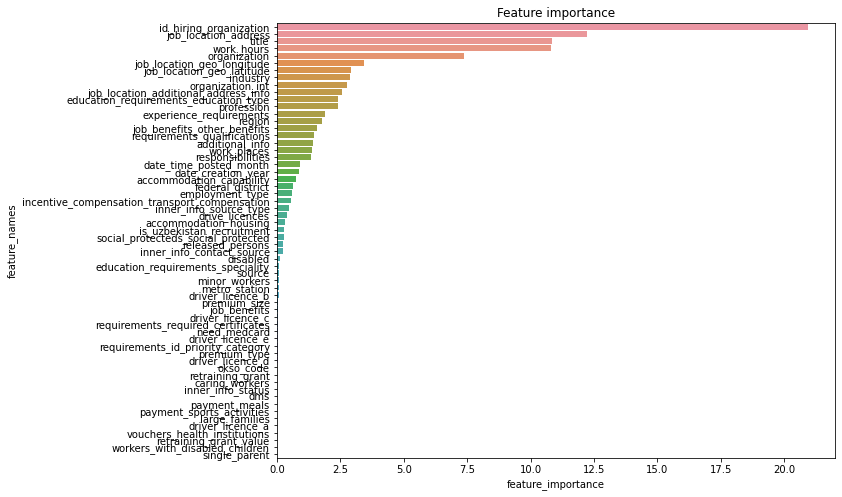

In [30]:
fi_df = plot_feature_importance(model.get_feature_importance(),train.drop(columns=[target_col]).columns)

In [32]:
fi_df
fi_df.to_csv('fi.csv', index=False)

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train.drop(columns=[target_col]))

In [ ]:
shap.summary_plot(shap_values, train.drop(columns=[target_col]))

In [ ]:
shap.dependence_plot("title", shap_values, train.drop(columns=[target_col]))

### Predict on test

In [28]:
preds = model.predict(test)
sample_subm['mean_salary'] = preds
sample_subm.to_csv('base_021.csv', index=False)
sample_subm

,id,mean_salary
0,1050815,14761.786518
1,1050816,20456.019385
2,1050817,30262.381286
3,1050818,25003.890086
4,1050819,33112.247520
...,...,...
39995,1090810,31579.131034
39996,1090811,34070.345761
39997,1090812,25277.369929
39998,1090813,17568.194732


### To do :
* Несколько моделей для разных годов / зарплат
* matual regression
* TabNetRegressor from pytorch_tabnet.tab_model import TabNetRegressor
* So, we need to log-transform y to train and exp-transform the predictions

<a href="./model.cbm"> Download File </a>